Packages

In [2]:
#packages
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Dropout, Input, concatenate, Bidirectional, SimpleRNN
from keras.optimizers import Adam
import tensorflow 
from keras import regularizers, initializers


import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from scipy.stats import ttest_rel
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.decomposition import PCA

In [3]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

In [4]:
#定义绘图函数：
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

#定义分箱函数：
#rolling分箱
def split_sequence(sequence,n_steps,n_forecast):
    a,b=list(),list()
    for i in range(len(sequence)):
        end_ix=i+n_steps
        end_ix_l=end_ix+n_forecast
        if end_ix_l>len(sequence):
            break
        seq_x,seq_y=sequence[i:end_ix],sequence[end_ix:end_ix_l]
        a.append(seq_x)
        b.append(seq_y)
        i=i+n_steps+n_forecast
    return np.array(a), np.array(b)

'''#分块分箱
def split_sequence(sequence,n_steps,n_forecast):
    a,b=list(),list()
    i=1
    while i <= len(sequence):
        end_ix=i+n_steps
        end_ix_l=end_ix+n_forecast-1
        if end_ix_l>len(sequence):
            break
        seq_x,seq_y=sequence[i-1:end_ix-1],sequence[end_ix-1:end_ix_l]
        a.append(seq_x)
        b.append(seq_y)
        i=i+n_steps+n_forecast
    return np.array(a), np.array(b)
'''

# define function to plot learning curve 学习曲线
def plot_learning_curve(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Learning Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

#normalization [0,1]维度加速训练
def max_min_normalize(data):
    """
    Perform Max-Min normalization on input data.

    Args:
        data (numpy array): Input data.

    Returns:
        numpy array: Normalized data.
    """
    # Check if data is 1D, 2D or 3D
    if len(data.shape) == 1:  # 1D data
        norm_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    elif len(data.shape) == 2:  # 2D data
        norm_data = np.zeros_like(data)
        for i in range(data.shape[1]):
            norm_data[:, i] = (data[:, i] - np.min(data[:, i])) / (np.max(data[:, i]) - np.min(data[:, i]))
    elif len(data.shape) == 3:  # 3D data
        norm_data = np.zeros_like(data)
        for i in range(data.shape[2]):
            norm_data[:, :, i] = (data[:, :, i] - np.min(data[:, :, i])) / (np.max(data[:, :, i]) - np.min(data[:, :, i]))
    else:
        raise ValueError("Input data must be 1D, 2D or 3D.")
        
    return norm_data



#测试每列预测值的偏差

def Var_output(preddata, truedata):
    list=[]
    for i in range(preddata.shape[1]):
        #print(i)
        diff=preddata[:,i]-truedata[:,i]
        var_i=np.var(diff)
        #print(i+diff)
        list.append(var_i)
    return list

def evaluate(y_true, y_pred, T):
    # 计算评估指标
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    # 返回评估指标和T检验结果
    return (f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, "
            f"MAPE: {mape:.4f}, R2: {r2:.4f}")

def evaluate2(y_true, y_pred, T):
    # 计算评估指标
    mae = mean_absolute_error(y_true[:,-1], y_pred[:,-1])
    mse = mean_squared_error(y_true[:,-1], y_pred[:,-1])
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true[:,-1] - y_pred[:,-1]) / y_true[:,-1])) * 100
    r2 = r2_score(y_true[:,-1], y_pred[:,-1])

    # 返回评估指标和T检验结果
    return (f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, "
            f"MAPE: {mape:.4f}, R2: {r2:.4f}")



#美丽散点图
def plot_scatter(y_true, y_pred, labels=None, title=None):
    """
    Plot scatter plot of true vs predicted values.

    Args:
        y_true (numpy array): True values.
        y_pred (numpy array): Predicted values.
        labels (list): List of strings, labels for the predicted values.
        title (str): Title of the plot.

    Returns:
        None
    """
    n_features = y_true.shape[1]

    # Create figure and axis objects
    fig, ax = plt.subplots()

    # Scatter plot
    for i in range(n_features):
        color = 'C' + str(i)
        label = f'Forecast Day {i+1}'
        if labels:
            label = labels[i]
        ax.scatter(y_true[:, i], y_pred[:, i], color=color, label=label)

    # Add diagonal line
    lims = [np.min(y_true), np.max(y_true)]
    ax.plot(lims, lims, color='red', linestyle='--')

    # Set axis labels and title
    ax.set_xlabel('True values')
    ax.set_ylabel('Predicted values')
    if title:
        ax.set_title(title)

    ax.legend()

    # Show plot
    plt.show()



def plot_time_series(actual, predicted, xlabel='Time (days)', ylabel=None, title=None):
    """
    Plots the actual and predicted time series data.

    Parameters:
    actual (array-like): The actual time series data.
    predicted (array-like): The predicted time series data.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    title (str): The title of the plot.

    Returns:
    None
    """
    fig, ax = plt.subplots(figsize=(12,6))

    ax.plot(actual, label='Actual')
    ax.plot(predicted, color='red', label='Predicted')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.legend()
    plt.show()


def calculate_correlation_matrix(*args, **kwargs):
    # 将输入数据合并为一个数组
    data = np.stack(args, axis=1)

    # 计算相关性矩阵
    corr_matrix = np.corrcoef(data, rowvar=False)
    #corr_matrix, _ = spearmanr(data, axis=0)

    # 绘制相关性矩阵图
    sns.set_theme(style="dark")
    mask = np.zeros_like(corr_matrix, dtype=bool)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    plt.figure(figsize=(8, 6))
    plt.title("Pearson Coefficient of Inputs")
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5},
                xticklabels=kwargs.get('names'), yticklabels=kwargs.get('names'))
    plt.show()



#特征提取，PCA
def apply_pca(df):
    # 取出TIME和Value列
    subset = df[['TIME', 'Value']]
    # 将Value列转化为二维数组
    values = subset['Value'].values.reshape(-1, 1)
    
    # 对Value列进行PCA
    pca = PCA(n_components=1)
    pca_values = pca.fit_transform(values)
    
    # 将TIME列和PCA后的Value列合并到新的DataFrame中
    result = pd.DataFrame({'TIME': subset['TIME'], 'Value': pca_values.ravel()})
    return result

from sklearn.preprocessing import StandardScaler

def calculate_pca_correlation_matrix(*args, **kwargs):
    # 将输入数据合并为一个数组
    data = np.stack(args, axis=1)

    # 对数据进行标准化
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # 计算协方差矩阵
    cov_matrix = np.cov(scaled_data.T)

    # 计算相关系数矩阵
    std_devs = np.sqrt(np.diag(cov_matrix))
    corr_matrix = cov_matrix / np.outer(std_devs, std_devs)

    # 绘制相关系数矩阵图
    sns.set_theme(style="dark")
    mask = np.zeros_like(corr_matrix, dtype=bool)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    plt.figure(figsize=(8, 6))
    plt.title("Correlation Matrix of Inputs")
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5},
                xticklabels=kwargs.get('names'), yticklabels=kwargs.get('names'))
    plt.xlabel(kwargs.get('xlabel'))
    plt.ylabel(kwargs.get('ylabel'))
    plt.show()



Data Preparation

In [5]:
import os

# Get the script directory
script_dir = os.path.dirname(os.path.abspath(__file__))

# Change the working directory to the script's directory
os.chdir(script_dir)

# Exchange Rate
with open('DEXJPUS.csv', 'r') as file:
    Er_JPUS = pd.read_csv(file)
    Er_JPUS['TIME'] = Er_JPUS['TIME'].str.slice(stop=7)
    Er_JPUS.columns = ['TIME', 'Value']

# Japan Producer Price Index
with open('PPI_JP.csv', 'r') as file:
    PPI_JP = pd.read_csv(file, header=None, nrows=519, skiprows=3)
    PPI_JP['TIME'] = PPI_JP['TIME'].str.replace('/', '-')
    PPI_JP.columns = ['TIME', 'Value']

# US Producer Price Index
with open('PPI_US.csv', 'r') as file:
    PPI_US = pd.read_csv(file)
    PPI_US['TIME'] = PPI_US['TIME'].str.slice(stop=7)
    PPI_US.columns = ['TIME', 'Value']

# Japan M1 Index
with open('M1_JP.csv', 'r') as file:
    M1_JP_raw = pd.read_csv(file)
    M1_JP = M1_JP_raw.loc[:, ['TIME', 'Value']]

# US M1 Index
with open('M1_US.csv', 'r') as file:
    M1_US_raw = pd.read_csv(file)
    M1_US = M1_US_raw.loc[:, ['TIME', 'Value']]

# Japan Industrial Production Index
with open('IPI_JP.csv', 'r') as file:
    IPI_JP = pd.read_csv(file)
    IPI_JP_SP = IPI_JP.loc[IPI_JP['Measure'] != 'Growth previous period', ['Measure', 'TIME', 'Value']]
    IPI_JP_PP = IPI_JP.loc[IPI_JP['Measure'] == 'Growth previous period', ['Measure', 'TIME', 'Value']]

# US Industrial Production Index
with open('IPI_US.csv', 'r') as file:
    IPI_US = pd.read_csv(file)
    IPI_US_SP = IPI_US.loc[IPI_US['Measure'] != 'Growth previous period', ['Measure', 'TIME', 'Value']]
    IPI_US_PP = IPI_US.loc[IPI_US['Measure'] == 'Growth previous period', ['Measure', 'TIME', 'Value']]

# Japan Bonds Yields
with open('IN_JP.csv', 'r') as file:
    IN_JP_raw = pd.read_csv(file)
    IN_JP_LT = IN_JP_raw.loc[IN_JP_raw['Subject'] == 'Long-term interest rates, Per cent per annum',
                            ['Subject', 'TIME', 'Value']]
    IN_JP_ST = IN_JP_raw.loc[IN_JP_raw['Subject'] == 'Short-term interest rates, Per cent per annum',
                            ['Subject', 'TIME', 'Value']]
    IN_JP_IM = IN_JP_raw.loc[IN_JP_raw['Subject'] == 'Immediate interest rates, Call Money, Interbank Rate, Per cent per annum',
                            ['Subject', 'TIME', 'Value']]

# US Bonds Yields
with open('IN_US.csv', 'r') as file:
    IN_US_raw = pd.read_csv(file)
    IN_US_LT = IN_US_raw.loc[IN_US_raw['Subject'] == 'Long-term interest rates, Per cent per annum',
                            ['Subject', 'TIME', 'Value']]
    IN_US_ST = IN_US_raw.loc[IN_US_raw['Subject'] == 'Short-term interest rates, Per cent per annum',
                            ['Subject', 'TIME', 'Value']]
    IN_US_IM = IN_US_raw.loc[IN_US_raw['Subject'] == 'Immediate interest rates, Call Money, Interbank Rate, Per cent per annum',
                            ['Subject', 'TIME', 'Value']]


Cross Validation -- def method


array([[<AxesSubplot:title={'center':'Value'}>]], dtype=object)

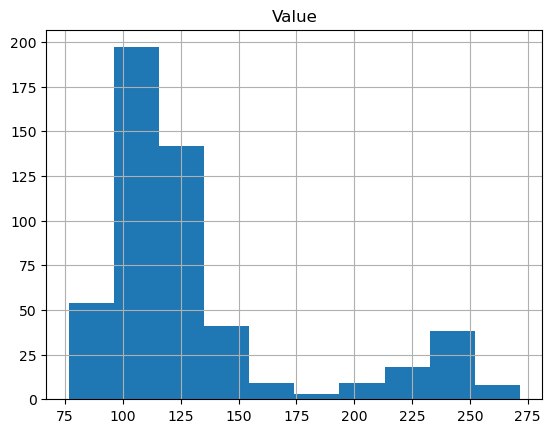

In [6]:
data=Er_JPUS['Value'].values

data.shape
Er_JPUS.hist()

In [7]:
'''用前m个月的数据, 预测后n个月的EX rate'''

n_month=5
n_forecast=1
learn,predict=split_sequence(data,n_month,n_forecast)
print(learn.shape,predict.shape)

(514, 5) (514, 1)


In [8]:
'''取前80%数据用于训练,后20%用于测试'''

n=int(predict.shape[0]*0.80)
print('训练量:'+str(n)+' 测试量:'+str(predict.shape[0]-n))
train_x=learn[:n]
train_y=predict[:n]
test_x=learn[n:]
test_y=predict[n:]
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)


训练量:411 测试量:103
(411, 5) (411, 1) (103, 5) (103, 1)


In [9]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
T=test_x.reshape((test_x.shape[0],test_x.shape[1],n_features))


--》开始尝试加入更多的特征

In [10]:
#快速转换数据格式
def transform(df_name,X,T,num):
    data_raw=df_name['Value'].values
    if len(data_raw) >= num :
        data_raw=data_raw[:num]
        print('renewed data size:'+ str(data_raw.shape))
        data_learn,data_predict=split_sequence(data_raw,n_month,n_forecast)
        n_data=int(data_predict.shape[0]*0.8)
        train_x=data_learn[:n_data]
        train_y=data_predict[:n_data]
        test_x=data_learn[n_data:] 
        test_y=data_learn[n_data:]
        print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)
        train_output = train_x.reshape(X.shape[0],X.shape[1],1)#trainning data
        test_output = test_x.reshape(T.shape[0],T.shape[1],1)#testing data
    else:
        print('num is too large, newly added data size:'+ str(len(data_raw)))
    return train_output, test_output, data_raw

 Direction one: Purchasing Power Parity 

In [11]:
num=519
#加入日本ppi
inf_jp,inf_jp_T, djpinf = transform(PPI_JP,X,T,num)
#加入美国ppi
inf_US,inf_US_T, dusinf = transform(PPI_US,X,T,num)

renewed data size:(519,)
(411, 5) (411, 1) (103, 5) (103, 5)
renewed data size:(519,)
(411, 5) (411, 1) (103, 5) (103, 5)


In [12]:
#通过broadcast合并特征
X_raw = np.concatenate((X, inf_jp, inf_US), axis=-1)

T_raw = np.concatenate((T, inf_jp_T, inf_US_T), axis=-1)

print(X_raw.shape,T_raw.shape)

(411, 5, 3) (103, 5, 3)


In [14]:
X_rawc = X_raw[:,:,0].reshape((411,5,1))
T_rawc = T_raw[:,:,0].reshape((103,5,1))

(411, 5, 3) (103, 5, 3)


2023-04-27 01:19:24.844126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 01:19:26.332417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 26ms/step


2023-04-27 01:19:44.336966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


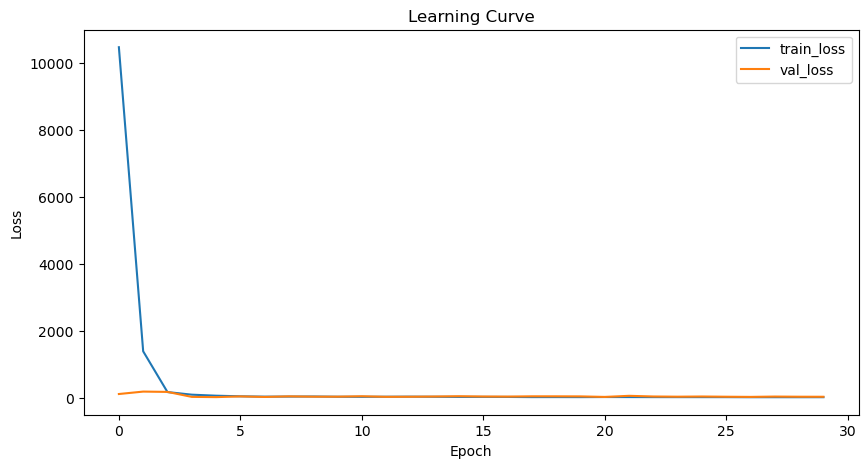

In [137]:
''' Vanilla LSTM'''
# define model
model_PPP = Sequential()
model_PPP.add(LSTM(64, activation='relu',kernel_regularizer=regularizers.l2(0.1), input_shape=(X_raw.shape[1], X_raw.shape[2])))
model_PPP.add(Dense(n_forecast))
model_PPP.compile(optimizer='adam', loss='mse')
print(X_raw.shape,T_raw.shape)
history=None
history = model_PPP.fit(X_raw, train_y, epochs=30, validation_data=(T_raw, test_y), verbose=0)
# demonstrate prediction
y_pred_PPP = model_PPP.predict(T_raw)
plot_learning_curve(history)

In [138]:
evaluate(test_y,y_pred_PPP, T_raw)

'MAE: 4.7799, MSE: 32.8801, RMSE: 5.7341, MAPE: 4.1224, R2: 0.6230'

(411, 5, 1) (103, 5, 1)


2023-04-27 01:20:29.657848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 01:20:31.123300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 37ms/step


2023-04-27 01:20:49.765260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


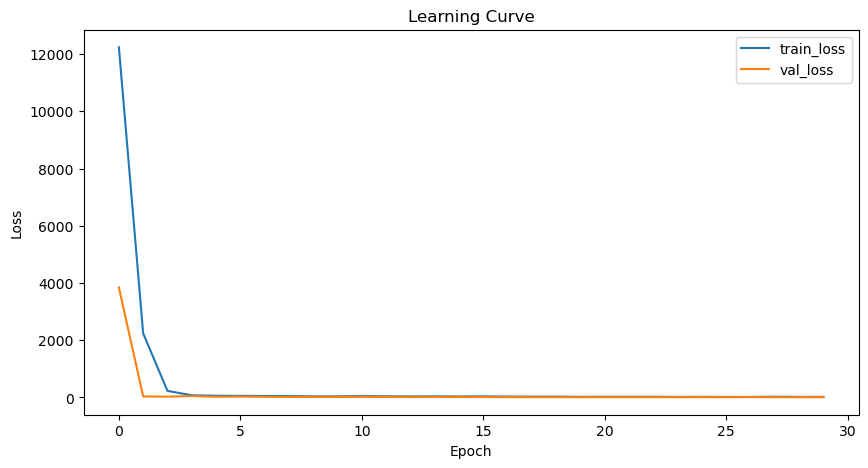

In [139]:
''' Vanilla LSTM'''
# define model
model_PPPc = Sequential()
model_PPPc.add(LSTM(64, activation='relu',kernel_regularizer=regularizers.l2(0.1), input_shape=(X_rawc.shape[1], X_rawc.shape[2])))
model_PPPc.add(Dense(n_forecast))
model_PPPc.compile(optimizer='adam', loss='mse')
print(X_rawc.shape,T_rawc.shape)
history=None
history = model_PPPc.fit(X_rawc, train_y, epochs=30, validation_data=(T_rawc, test_y), verbose=0)
# demonstrate prediction
y_pred_PPPc = model_PPPc.predict(T_rawc)
plot_learning_curve(history)

In [140]:
evaluate(test_y,y_pred_PPPc, T_rawc)

'MAE: 2.1678, MSE: 8.9601, RMSE: 2.9933, MAPE: 1.8658, R2: 0.8973'

In [141]:
'''Compare PPP against pure'''
from DMtest import dm_test
y= test_y.flatten().tolist()
y_pred1= y_pred_PPP.flatten().tolist()
y_pred2= y_pred_PPPc.flatten().tolist()
rt = dm_test(y,y_pred1,y_pred2,h = 1, crit="poly", power=2)
print(rt)

dm_return(DM=6.323503668971514, p_value=6.849233850075711e-09)


(411, 5, 3) (103, 5, 3)


2023-04-27 01:22:32.583735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 01:22:34.911367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/4 [=====================>........] - ETA: 0s

2023-04-27 01:23:32.736965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 66ms/step


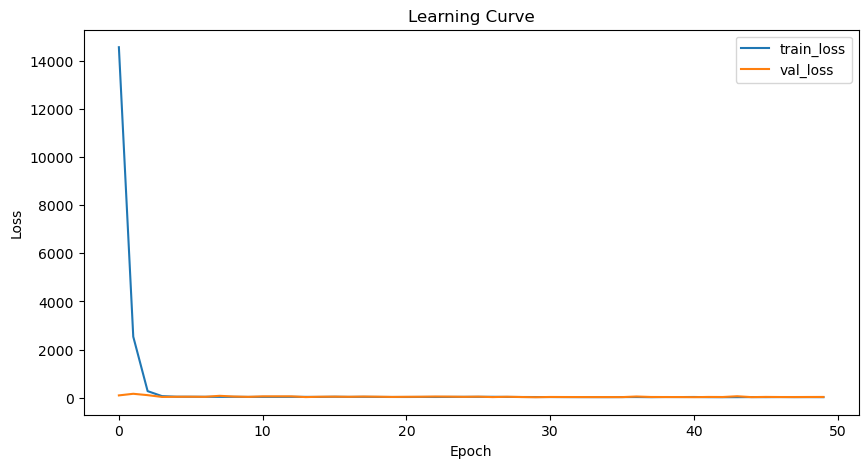

In [142]:
'''Bidirectional LSTM model'''

from keras.layers import Bidirectional
#define the model
model_PPP2 = Sequential()
model_PPP2.add(Bidirectional(LSTM(64, activation='relu',kernel_regularizer=regularizers.l2(0.1)), input_shape=(X_raw.shape[1], X_raw.shape[2])))
model_PPP2.add(Dense(n_forecast))
model_PPP2.compile(optimizer='adam', loss='mse')
print(X_raw.shape,T_raw.shape)
history=None
history = model_PPP2.fit(X_raw, train_y, epochs=50, validation_data=(T_raw, test_y), verbose=0)
# demonstrate prediction
y_pred_PPP2 = model_PPP2.predict(T_raw)
plot_learning_curve(history)

In [143]:
evaluate(test_y,y_pred_PPP2, T_raw)

'MAE: 4.0933, MSE: 29.1086, RMSE: 5.3952, MAPE: 3.4727, R2: 0.6662'

(411, 5, 1) (103, 5, 1)


2023-04-27 01:23:51.263389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 01:23:54.085918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2023-04-27 01:24:53.379999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 69ms/step


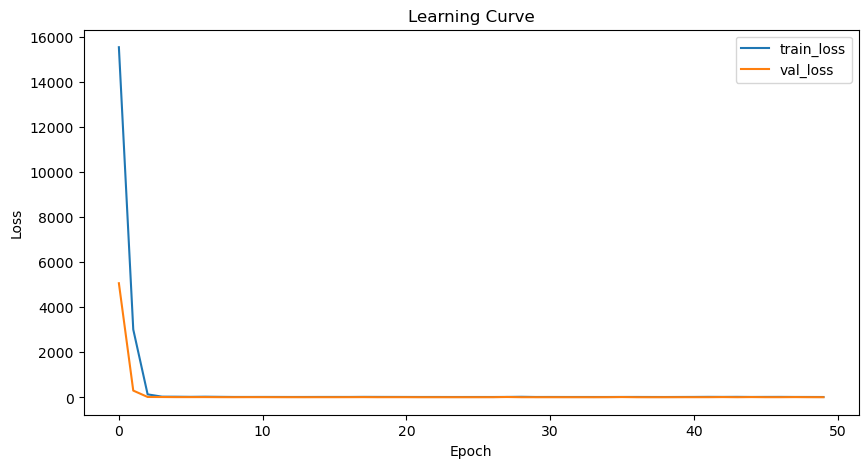

In [144]:
'''Bidirectional LSTM model'''

from keras.layers import Bidirectional
#define the model
model_PPP2c = Sequential()
model_PPP2c.add(Bidirectional(LSTM(64, activation='relu',kernel_regularizer=regularizers.l2(0.1)), input_shape=(X_rawc.shape[1], X_rawc.shape[2])))
model_PPP2c.add(Dense(n_forecast))
model_PPP2c.compile(optimizer='adam', loss='mse')
print(X_rawc.shape,T_rawc.shape)
history=None
history = model_PPP2c.fit(X_rawc, train_y, epochs=50, validation_data=(T_rawc, test_y), verbose=0)
# demonstrate prediction
y_pred_PPP2c = model_PPP2c.predict(T_rawc)
plot_learning_curve(history)

In [145]:
evaluate(test_y,y_pred_PPP2c, T_rawc)

'MAE: 2.2039, MSE: 8.9681, RMSE: 2.9947, MAPE: 1.8758, R2: 0.8972'

In [146]:
'''Compare PPP against pure'''
from DMtest import dm_test
y= test_y.flatten().tolist()
y_pred1= y_pred_PPP2.flatten().tolist()
y_pred2= y_pred_PPP2c.flatten().tolist()
rt = dm_test(y,y_pred1,y_pred2,h = 1, crit="poly", power=2)
print(rt)

dm_return(DM=5.747923113349423, p_value=9.450992428365051e-08)


(411, 5, 3) (103, 5, 3)


2023-04-27 10:33:18.796012: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-27 10:33:19.115719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 10:33:19.735062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 7ms/step


2023-04-27 10:33:32.576454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


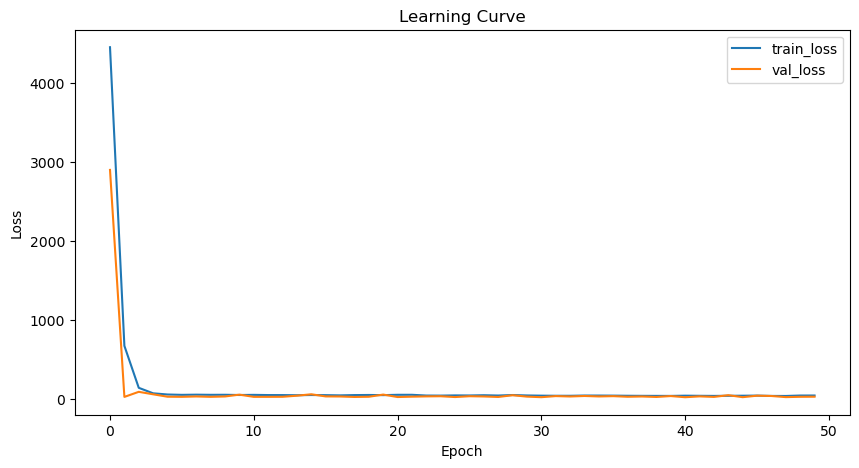

In [15]:
'''simple RNN model'''

#define the model
model_PPP3 = Sequential()
model_PPP3.add(SimpleRNN(100, activation='relu', kernel_regularizer=regularizers.l2(0.3), input_shape=(X_raw.shape[1], X_raw.shape[2])))
model_PPP3.add(Dense(n_forecast))
model_PPP3.compile(optimizer='adam', loss='mse')
print(X_raw.shape,T_raw.shape)
history=None
history = model_PPP3.fit(X_raw, train_y, epochs=50, validation_data=(T_raw, test_y), verbose=0)
# demonstrate prediction
y_pred_PPP3 = model_PPP3.predict(T_raw)
plot_learning_curve(history)

In [16]:
evaluate(test_y,y_pred_PPP3, T_raw)

'MAE: 3.5844, MSE: 21.8059, RMSE: 4.6697, MAPE: 3.0453, R2: 0.7500'

(411, 5, 1) (103, 5, 1)


2023-04-27 10:33:37.630779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 10:33:38.240952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 8ms/step


2023-04-27 10:33:51.189813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


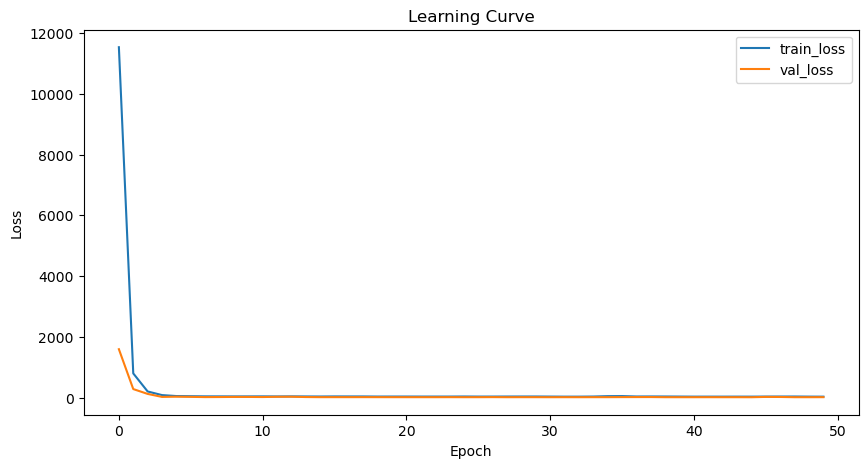

In [17]:
'''simple RNN model'''

#define the model
model_PPP3c = Sequential()
model_PPP3c.add(SimpleRNN(100, activation='relu', kernel_regularizer=regularizers.l2(0.3), input_shape=(X_rawc.shape[1], X_rawc.shape[2])))
model_PPP3c.add(Dense(n_forecast))
model_PPP3c.compile(optimizer='adam', loss='mse')
print(X_rawc.shape,T_rawc.shape)
history=None
history = model_PPP3c.fit(X_rawc, train_y, epochs=50, validation_data=(T_rawc, test_y), verbose=0)
# demonstrate prediction
y_pred_PPP3c = model_PPP3c.predict(T_rawc)
plot_learning_curve(history)

In [18]:
evaluate(test_y,y_pred_PPP3c, T_rawc)

'MAE: 2.9874, MSE: 15.0306, RMSE: 3.8769, MAPE: 2.5951, R2: 0.8277'

In [19]:
'''Compare PPP against pure'''
from DMtest import dm_test
y= test_y.flatten().tolist()
y_pred1= y_pred_PPP3.flatten().tolist()
y_pred2= y_pred_PPP3c.flatten().tolist()
rt = dm_test(y,y_pred1,y_pred2,h = 1, crit="poly", power=2)
print(rt)

dm_return(DM=1.9211254027692124, p_value=0.05750764350365796)


-->Direction two: Monetary Model

In [11]:
data2 = data[:-2]
learn2,predict2=split_sequence(data2,n_month,n_forecast)
n2=int(predict2.shape[0]*0.8)
print(n2)
'''取前80%数据用于训练,后20%用于测试'''
train_x2=learn2[:n2]
train_y2=predict2[:n2]
test_x2=learn2[n2:]
test_y2=predict2[n2:]
print(train_x2.shape,train_y2.shape,test_x2.shape,test_y2.shape)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_2 = train_x2.reshape((train_x2.shape[0], train_x2.shape[1], n_features))
T_2=test_x2.reshape((test_x2.shape[0],test_x2.shape[1],n_features))

num2=data2.shape[0]

409
(409, 5) (409, 1) (103, 5) (103, 1)


In [12]:
'''Price Gap (p-p*)'''

inf_jp,inf_jp_T, djpinf2 = transform(PPI_JP,X_2,T_2,num2)
inf_US,inf_US_T, dusinf2 = transform(PPI_US,X_2,T_2,num2)

log_price_gap_train = np.log(inf_US)-np.log(inf_jp) #trainning data
log_price_gap_test = np.log(inf_US_T)-np.log(inf_jp_T) #testing data


'''Output Gap (y-y*)'''

ipi_jp,ipi_jp_T, djpipi2 = transform(IPI_JP,X_2,T_2,num2)
ipi_US,ipi_US_T, dusipi2 = transform(IPI_US,X_2,T_2,num2)

#output ipi index 取得是base2015=100，所以没法做logarithm
output_gap_train = ipi_US - ipi_jp #trainning data
output_gap_test = ipi_US_T - ipi_jp_T #testing data


'''Monetary Demand Gap (M1-M1*)'''

m1_jp,m1_jp_T, djpm12 = transform(M1_JP,X_2,T_2,num2)
m1_US,m1_US_T, dusm12 = transform(M1_US,X_2,T_2,num2)

MD_gap_train = np.log(m1_US) - np.log(m1_jp) #trainning data
MD_gap_test = np.log(m1_US_T) - np.log(m1_jp_T) #testing data

renewed data size:(517,)
(409, 5) (409, 1) (103, 5) (103, 5)
renewed data size:(517,)
(409, 5) (409, 1) (103, 5) (103, 5)
renewed data size:(517,)
(409, 5) (409, 1) (103, 5) (103, 5)
renewed data size:(517,)
(409, 5) (409, 1) (103, 5) (103, 5)
renewed data size:(517,)
(409, 5) (409, 1) (103, 5) (103, 5)
renewed data size:(517,)
(409, 5) (409, 1) (103, 5) (103, 5)


In [13]:
#通过broadcast合并特征
X_2 = np.concatenate((X_2, log_price_gap_train, output_gap_train, MD_gap_train), axis=-1)

T_2 = np.concatenate((T_2, log_price_gap_test, output_gap_test, MD_gap_test), axis=-1)

print(X_2.shape,T_2.shape)

(409, 5, 4) (103, 5, 4)


In [14]:
X_2c = X_2[:,:,0].reshape((409,5,1))
T_2c = T_2[:,:,0].reshape((103,5,1))

In [26]:
'''Vanilla LSTM'''
# define model
model_MM = Sequential()
model_MM.add(LSTM(64, activation='relu', kernel_regularizer=regularizers.l2(0.1),input_shape=(X_2.shape[1], X_2.shape[2])))
model_MM.add(Dense(n_forecast))
model_MM.compile(optimizer='adam', loss='mse')
print(X_2.shape,T_2.shape)

(409, 5, 4) (103, 5, 4)


2023-04-27 00:30:50.951157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 00:30:51.834882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 15ms/step


2023-04-27 00:31:17.277249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


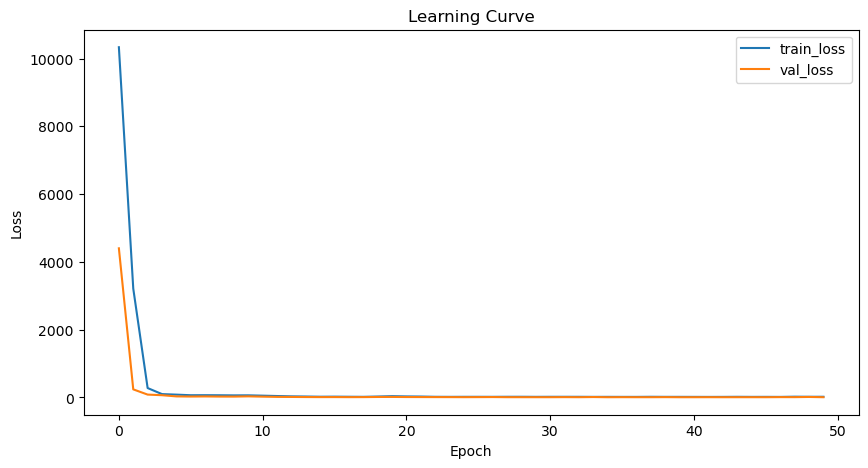

In [27]:
history=None
history = model_MM.fit(X_2, train_y2, epochs=50, validation_data=(T_2, test_y2), verbose=0)
# demonstrate prediction
y_pred_MM = model_MM.predict(T_2)
plot_learning_curve(history)

In [28]:
evaluate(test_y2,y_pred_MM, T_2)

'MAE: 2.0444, MSE: 8.1880, RMSE: 2.8615, MAPE: 1.7497, R2: 0.9007'

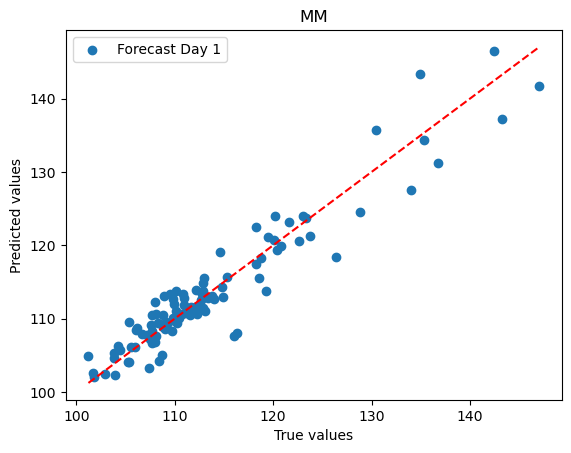

In [29]:
plot_scatter(test_y2,y_pred_MM,title='MM')

In [30]:
'''Vanilla LSTM'''
# define model
model_MMc = Sequential()
model_MMc.add(LSTM(64, activation='relu', kernel_regularizer=regularizers.l2(0.1),input_shape=(X_2c.shape[1], X_2c.shape[2])))
model_MMc.add(Dense(n_forecast))
model_MMc.compile(optimizer='adam', loss='mse')
print(X_2c.shape,T_2c.shape)

(409, 5, 1) (103, 5, 1)


2023-04-27 00:31:28.145664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 00:31:29.063862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 16ms/step


2023-04-27 00:31:55.445880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


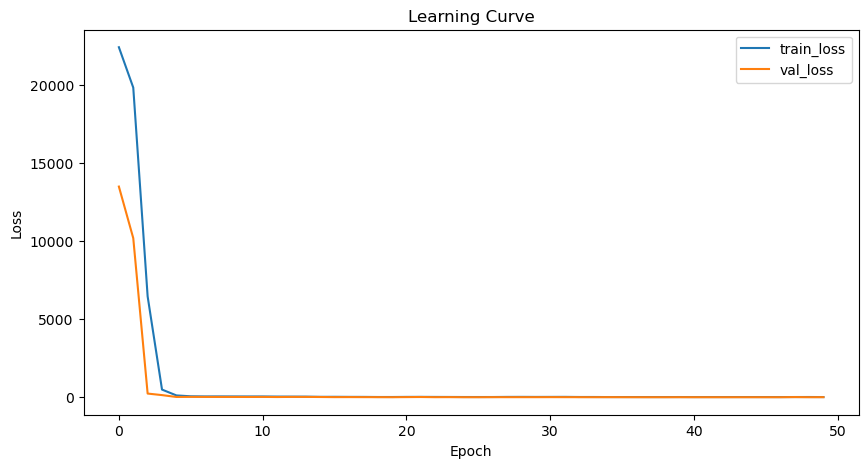

In [31]:
history=None
history = model_MMc.fit(X_2c, train_y2, epochs=50, validation_data=(T_2c, test_y2), verbose=0)
# demonstrate prediction
y_pred_MMc = model_MMc.predict(T_2c)
plot_learning_curve(history)

In [32]:
evaluate(test_y2,y_pred_MMc, T_2c)

'MAE: 2.5903, MSE: 11.7047, RMSE: 3.4212, MAPE: 2.2175, R2: 0.8580'

In [37]:
'''Compare MM against pure'''
from DMtest import dm_test
y= test_y2.flatten().tolist()
y_pred1= y_pred_MM.flatten().tolist()
y_pred2= y_pred_MMc.flatten().tolist()
rt = dm_test(y,y_pred1,y_pred2,h = 1, crit="poly", power=2)
print(rt)

dm_return(DM=-2.8078623944017886, p_value=0.0059766453194479464)


In [18]:
'''Bidirectional LSTM model'''

from keras.layers import Bidirectional
#define the model
model_MM3 = Sequential()
model_MM3.add(Bidirectional(LSTM(64, activation='relu',kernel_regularizer=regularizers.l2(0.1)), input_shape=(X_2.shape[1], X_2.shape[2])))
model_MM3.add(Dense(n_forecast))
model_MM3.compile(optimizer='adam', loss='mse')
print(X_2.shape,T_2.shape)

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-27 00:26:53.960975: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-27 00:26:53.961169: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(409, 5, 4) (103, 5, 4)


2023-04-27 00:26:59.633338: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-27 00:27:00.311694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 00:27:02.133749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


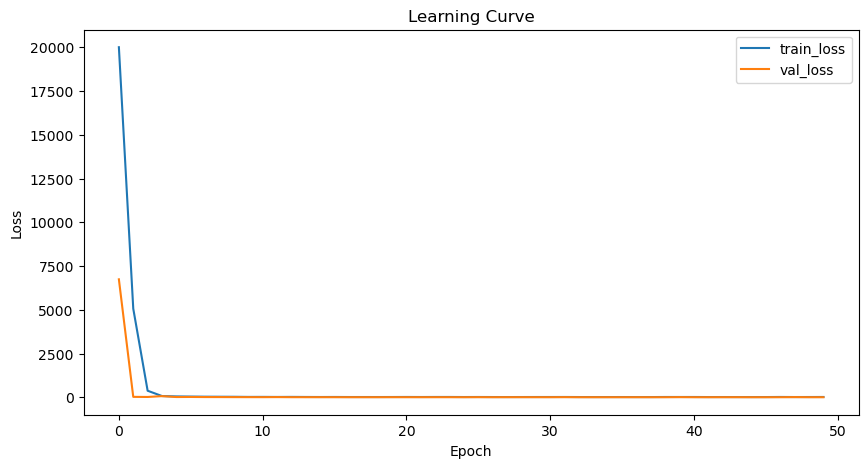

4/4 [==============================] - 0s 24ms/step


2023-04-27 00:27:51.271745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [19]:
# train the model and plot learning curve
history = None
history = model_MM3.fit(X_2, train_y2, epochs=50, validation_data=(T_2, test_y2), verbose=0)
plot_learning_curve(history)
# demonstrate prediction
y_pred_MM3 = model_MM3.predict(T_2)

In [38]:
evaluate(test_y2,y_pred_MM3, T_2)

'MAE: 1.8423, MSE: 6.7257, RMSE: 2.5934, MAPE: 1.5760, R2: 0.9184'

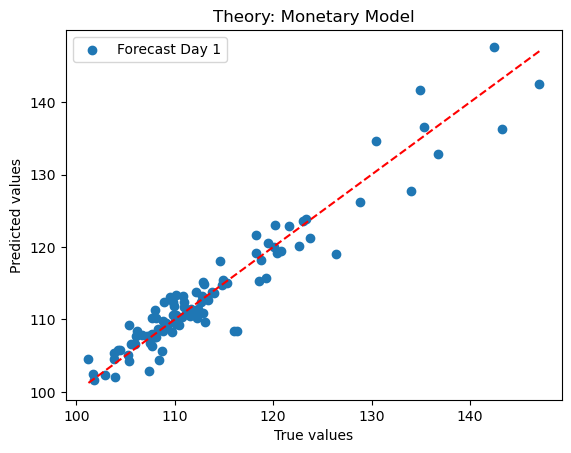

In [48]:
plot_scatter(test_y2,y_pred_MM3,title='Theory: Monetary Model')

In [51]:
'''Bidirectional LSTM model'''

from keras.layers import Bidirectional
#define the model
model_MM3c = Sequential()
model_MM3c.add(Bidirectional(LSTM(32, activation='relu',kernel_regularizer=regularizers.l2(0.1)), input_shape=(X_2c.shape[1], X_2c.shape[2])))
model_MM3c.add(Dense(n_forecast))
model_MM3c.compile(optimizer='adam', loss='mse')
print(X_2c.shape,T_2c.shape)

(409, 5, 1) (103, 5, 1)


2023-04-27 00:41:10.987379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 00:41:12.839482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2023-04-27 00:42:01.801387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 32ms/step


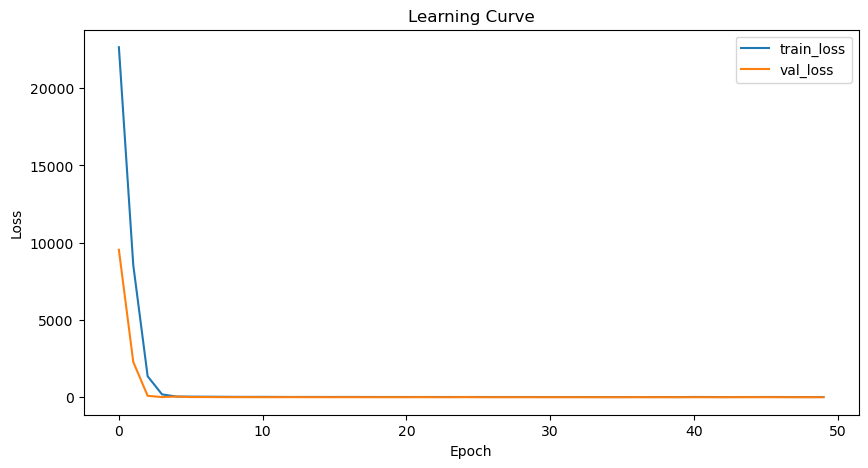

In [52]:
history=None
history = model_MM3c.fit(X_2c, train_y2, epochs=50, validation_data=(T_2c, test_y2), verbose=0)
# demonstrate prediction
y_pred_MM3c = model_MM3c.predict(T_2c)
plot_learning_curve(history)

In [53]:
evaluate(test_y2,y_pred_MM3c, T_2)

'MAE: 1.9059, MSE: 7.6030, RMSE: 2.7573, MAPE: 1.6184, R2: 0.9078'

In [54]:
'''Compare MM against pure'''
from DMtest import dm_test
y= test_y2.flatten().tolist()
y_pred13= y_pred_MM3.flatten().tolist()
y_pred23= y_pred_MM3c.flatten().tolist()
rt = dm_test(y,y_pred13,y_pred23,h = 1, crit="poly", power=2)
print(rt)

dm_return(DM=-1.854288806889745, p_value=0.06658695267139086)


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

(409, 5, 4) (103, 5, 4)


2023-04-27 11:26:27.571461: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-27 11:26:27.571620: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-27 11:26:27.742129: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-27 11:26:28.108217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 11:26:28.686671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 7ms/step


2023-04-27 11:26:41.704348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


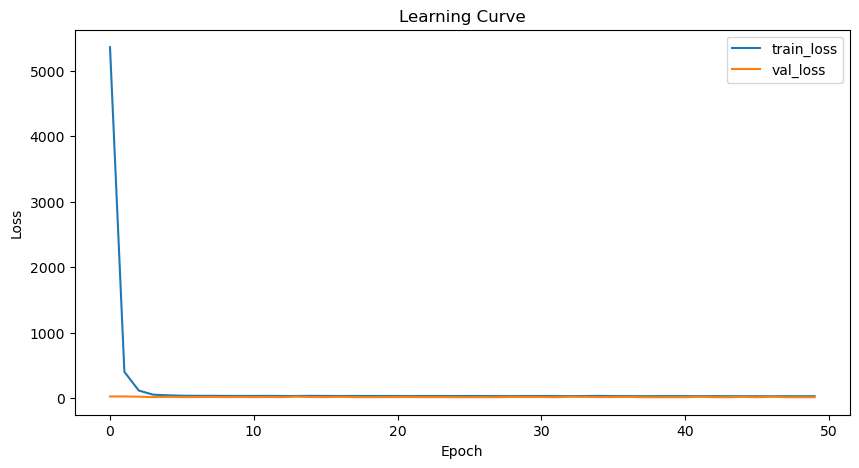

In [15]:
'''Simple RNNs'''
# define model
model_MM4 = Sequential()
model_MM4.add(SimpleRNN(64, activation='relu', kernel_regularizer=regularizers.l2(0.1),input_shape=(X_2.shape[1], X_2.shape[2])))
model_MM4.add(Dense(n_forecast))
model_MM4.compile(optimizer='adam', loss='mse')
print(X_2.shape,T_2.shape)
history=None
history = model_MM4.fit(X_2, train_y2, epochs=50, validation_data=(T_2, test_y2), verbose=0)
# demonstrate prediction
y_pred_MM4 = model_MM4.predict(T_2)
plot_learning_curve(history)

In [16]:
evaluate(test_y2,y_pred_MM4, T_2)

'MAE: 2.5128, MSE: 12.1300, RMSE: 3.4828, MAPE: 2.1445, R2: 0.8529'

(409, 5, 1) (103, 5, 1)


2023-04-27 11:26:48.536347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 11:26:49.055127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 8ms/step


2023-04-27 11:27:02.179189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


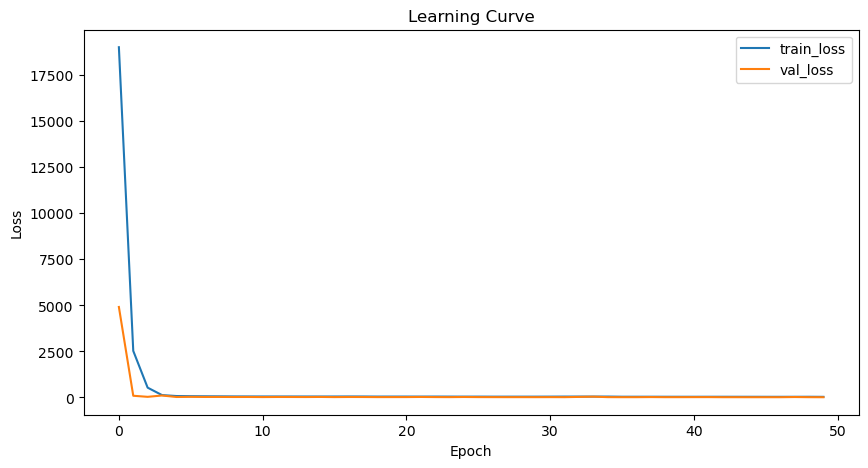

In [17]:
'''Simple RNNs'''
# define model
model_MM4c = Sequential()
model_MM4c.add(SimpleRNN(64, activation='relu', kernel_regularizer=regularizers.l2(0.1),input_shape=(X_2c.shape[1], X_2c.shape[2])))
model_MM4c.add(Dense(n_forecast))
model_MM4c.compile(optimizer='adam', loss='mse')
print(X_2c.shape,T_2c.shape)
history=None
history = model_MM4c.fit(X_2c, train_y2, epochs=50, validation_data=(T_2c, test_y2), verbose=0)
# demonstrate prediction
y_pred_MM4c = model_MM4c.predict(T_2c)
plot_learning_curve(history)

In [18]:
evaluate(test_y2,y_pred_MM4c, T_2c)

'MAE: 2.6679, MSE: 14.3426, RMSE: 3.7872, MAPE: 2.2946, R2: 0.8260'

In [21]:
'''Compare MM against pure'''
from DMtest import dm_test
y= test_y2.flatten().tolist()
y_pred13= y_pred_MM4.flatten().tolist()
y_pred23= y_pred_MM4c.flatten().tolist()
rt = dm_test(y,y_pred13,y_pred23,h = 1, crit="poly", power=2)
print(rt)

dm_return(DM=-1.9002033092984614, p_value=0.06023031637568598)


-->Direction three: UIRP

In [63]:
data3=data[66:] # 日本数据始于1985-07，与之对齐
print(len(data3))

learn3,predict3=split_sequence(data3,n_month,n_forecast)
n3=int(predict3.shape[0]*0.8)
print(n3)
'''取前80%数据用于训练,后20%用于测试'''
train_x3=learn3[:n3]
train_y_IR=predict3[:n3]
test_x3=learn3[n3:]
test_y_IR=predict3[n3:]
print(train_x3.shape,train_y_IR.shape,test_x3.shape,test_y_IR.shape)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_IR = train_x3.reshape((train_x3.shape[0], train_x3.shape[1], n_features))
T_IR=test_x3.reshape((test_x3.shape[0],test_x3.shape[1],n_features))

num3=data3.shape[0]

print(X_IR.shape,T_IR.shape)

453
358
(358, 5) (358, 1) (90, 5) (90, 1)
(358, 5, 1) (90, 5, 1)


In [64]:
IN_JP_IM_train,IN_JP_IM_test,djpin = transform(IN_JP_IM,X_IR,T_IR,num3)

IN_US_IM_train,IN_US_IM_test,dusin = transform(IN_US_IM.iloc[66:],X_IR,T_IR,num3)

renewed data size:(453,)
(358, 5) (358, 1) (90, 5) (90, 5)
renewed data size:(453,)
(358, 5) (358, 1) (90, 5) (90, 5)


In [65]:
#通过broadcast合并特征
X_IR = np.concatenate((X_IR, IN_JP_IM_train,IN_US_IM_train), axis=-1)

T_IR = np.concatenate((T_IR, IN_JP_IM_test,IN_US_IM_test), axis=-1)

print(X_IR.shape,T_IR.shape)

(358, 5, 3) (90, 5, 3)


In [67]:
X_IRc = X_IR[:,:,0].reshape((358,5,1))
T_IRc = T_IR[:,:,0].reshape((90,5,1))

In [58]:
'''Vanilla LSTM'''
# define model
model_UIRP = Sequential()
model_UIRP.add(LSTM(64, activation='relu', kernel_regularizer=regularizers.l2(0.1),input_shape=(X_IR.shape[1], X_IR.shape[2])))
model_UIRP.add(Dense(n_forecast))
model_UIRP.compile(optimizer='adam', loss='mse')

2023-04-27 00:43:14.799639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 00:43:16.018529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


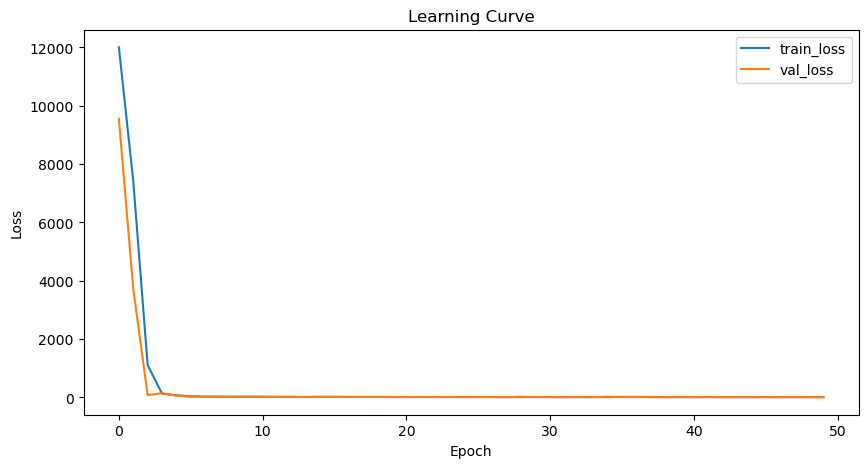

3/3 [==============================] - 0s 24ms/step


2023-04-27 00:43:42.567052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [59]:
# train the model and plot learning curve
history = None
history = model_UIRP.fit(X_IR, train_y_IR, epochs=50, validation_data=(T_IR, test_y_IR), verbose=0)
plot_learning_curve(history)
# demonstrate prediction
y_pred_UIRP = model_UIRP.predict(T_IR)

In [75]:
evaluate(test_y_IR,y_pred_UIRP, T_IR)

'MAE: 1.8790, MSE: 7.1455, RMSE: 2.6731, MAPE: 1.5916, R2: 0.9234'

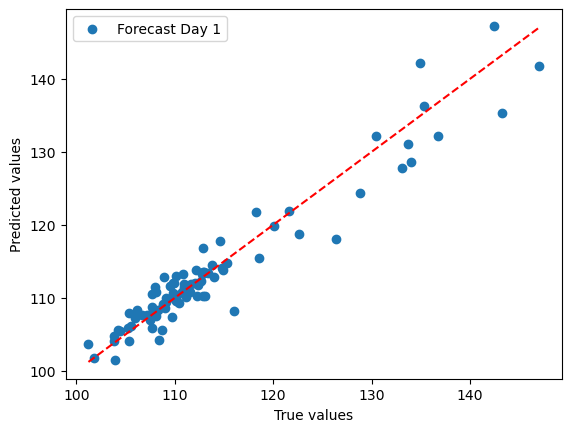

In [70]:
plot_scatter(test_y_IR,y_pred_UIRP)

2023-04-27 00:50:19.159883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 00:50:20.179504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


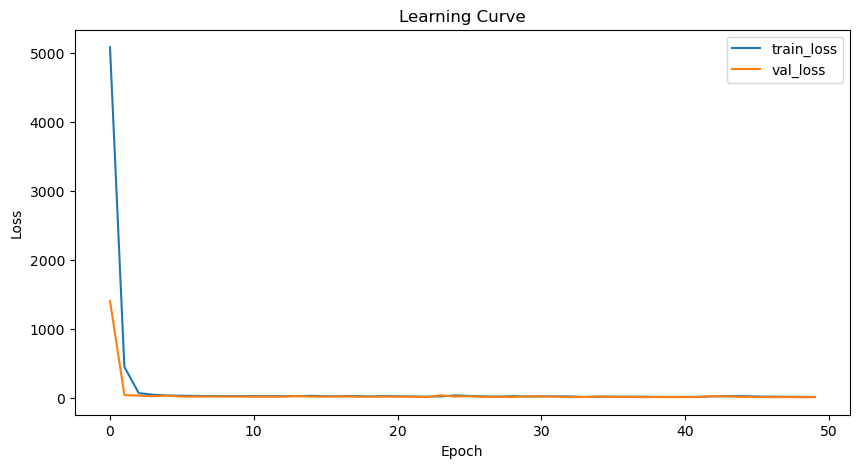

3/3 [==============================] - 0s 22ms/step


2023-04-27 00:50:43.917942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [76]:
'''Vanilla LSTM'''
# define model
model_UIRPc = Sequential()
model_UIRPc.add(LSTM(64, activation='relu', kernel_regularizer=regularizers.l2(0.1),input_shape=(X_IRc.shape[1], X_IRc.shape[2])))
model_UIRPc.add(Dense(n_forecast))
model_UIRPc.compile(optimizer='adam', loss='mse')

# train the model and plot learning curve
history = None
history = model_UIRPc.fit(X_IRc, train_y_IR, epochs=50, validation_data=(T_IRc, test_y_IR), verbose=0)
plot_learning_curve(history)
# demonstrate prediction
y_pred_UIRPc = model_UIRPc.predict(T_IRc)

In [77]:
evaluate(test_y_IR,y_pred_UIRPc, T_IRc)

'MAE: 1.8865, MSE: 7.0188, RMSE: 2.6493, MAPE: 1.6014, R2: 0.9248'

In [78]:
'''Compare UIRP against pure'''
from DMtest import dm_test
y= test_y_IR.flatten().tolist()
y_pred_u1= y_pred_UIRP.flatten().tolist()
y_pred_u2= y_pred_UIRPc.flatten().tolist()
rt = dm_test(y,y_pred_u1,y_pred_u2,h = 1, crit="poly", power=2)
print(rt)

dm_return(DM=0.4646423097202092, p_value=0.6433223359224489)


In [82]:
'''Bidirectional LSTM model'''

from keras.layers import Bidirectional
#define the model
model_UIRP2 = Sequential()
model_UIRP2.add(Bidirectional(LSTM(128, activation='relu',kernel_regularizer=regularizers.l2(0.1)), input_shape=(X_IR.shape[1], X_IR.shape[2])))
model_UIRP2.add(Dense(n_forecast))
model_UIRP2.compile(optimizer='adam', loss='mse')


2023-04-27 00:54:12.834263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 00:54:14.790916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


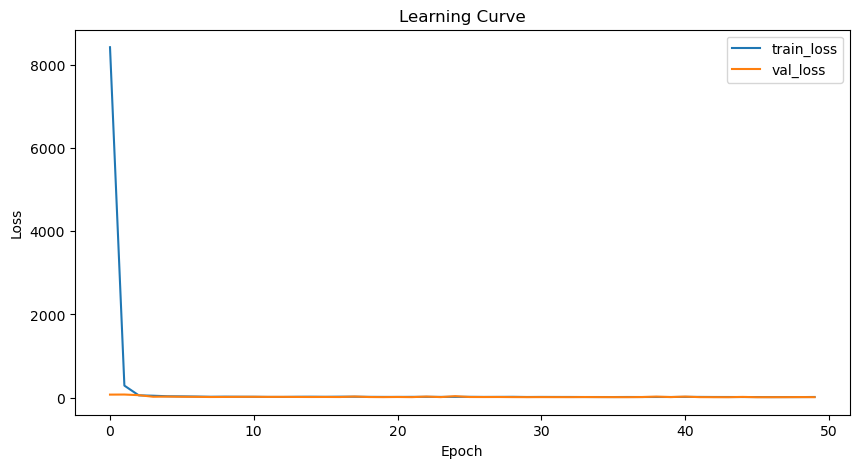

3/3 [==============================] - 0s 39ms/step


2023-04-27 00:55:01.063638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [83]:
# train the model and plot learning curve
history = None
history = model_UIRP2.fit(X_IR, train_y_IR, epochs=50, validation_data=(T_IR, test_y_IR), verbose=0)
plot_learning_curve(history)
# demonstrate prediction
y_pred_UIRP2 = model_UIRP2.predict(T_IR)

In [84]:
evaluate(test_y_IR,y_pred_UIRP2, T_IR)

'MAE: 2.1276, MSE: 8.4557, RMSE: 2.9079, MAPE: 1.8077, R2: 0.9094'

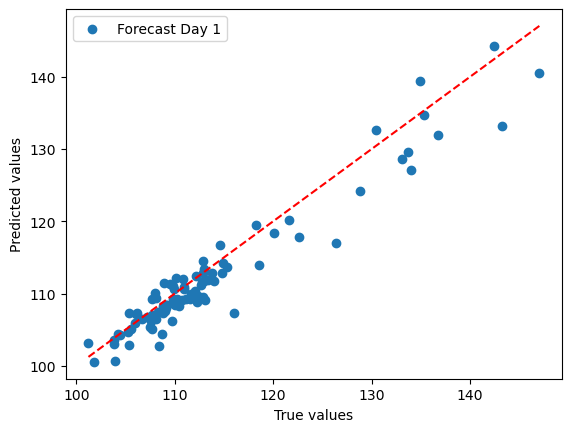

In [85]:
plot_scatter(test_y_IR,y_pred_UIRP2)

2023-04-27 00:55:32.325963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 00:55:34.327130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


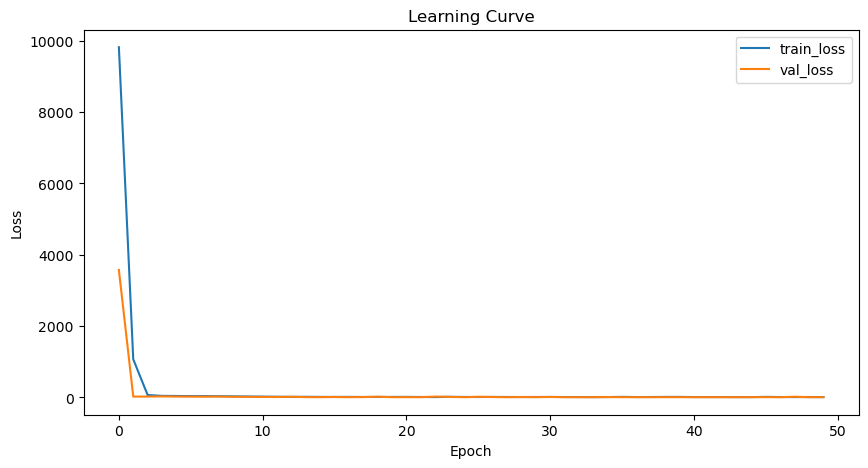

1/3 [=========>....................] - ETA: 0s

2023-04-27 00:56:23.143051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 53ms/step


In [86]:
'''Bidirectional LSTM model'''

from keras.layers import Bidirectional
#define the model
model_UIRP2c = Sequential()
model_UIRP2c.add(Bidirectional(LSTM(128, activation='relu',kernel_regularizer=regularizers.l2(0.1)), input_shape=(X_IRc.shape[1], X_IRc.shape[2])))
model_UIRP2c.add(Dense(n_forecast))
model_UIRP2c.compile(optimizer='adam', loss='mse')

# train the model and plot learning curve
history = None
history = model_UIRP2c.fit(X_IRc, train_y_IR, epochs=50, validation_data=(T_IRc, test_y_IR), verbose=0)
plot_learning_curve(history)
# demonstrate prediction
y_pred_UIRP2c = model_UIRP2c.predict(T_IRc)


In [87]:
evaluate(test_y_IR,y_pred_UIRP2c, T_IR)

'MAE: 1.9453, MSE: 6.9833, RMSE: 2.6426, MAPE: 1.6737, R2: 0.9252'

In [88]:
'''Compare UIRP against pure'''
from DMtest import dm_test
y= test_y_IR.flatten().tolist()
y_pred_u3= y_pred_UIRP2.flatten().tolist()
y_pred_u4= y_pred_UIRP2c.flatten().tolist()
rt = dm_test(y,y_pred_u3,y_pred_u4,h = 1, crit="poly", power=2)
print(rt)

dm_return(DM=1.1634332028203542, p_value=0.24776350993953475)


In [89]:
'''Simple RNN'''
#define the model
model_UIRP3 = Sequential()
model_UIRP3.add(SimpleRNN(100, activation='relu', kernel_regularizer=regularizers.l2(0.3), input_shape=(X_IR.shape[1], X_IR.shape[2])))
model_UIRP3.add(Dense(n_forecast))
model_UIRP3.compile(optimizer='adam', loss='mse')

2023-04-27 00:57:21.529798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 00:57:22.297839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


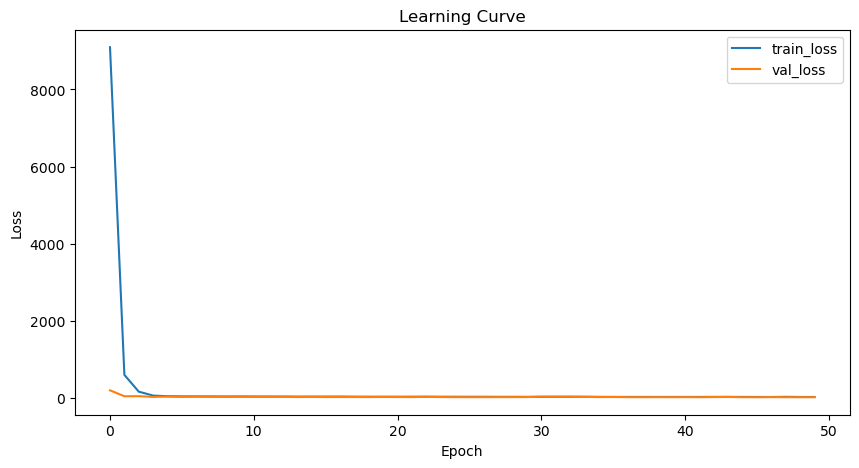

3/3 [==============================] - 0s 15ms/step


2023-04-27 00:57:35.392620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [90]:
# train the model and plot learning curve
history = None
history = model_UIRP3.fit(X_IR, train_y_IR, epochs=50, validation_data=(T_IR, test_y_IR), verbose=0)
plot_learning_curve(history)
# demonstrate prediction
y_pred_UIRP3 = model_UIRP3.predict(T_IR)

In [91]:
evaluate(test_y_IR,y_pred_UIRP3, T_IR)

'MAE: 2.4948, MSE: 12.4300, RMSE: 3.5256, MAPE: 2.1416, R2: 0.8668'

2023-04-27 00:58:49.132592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 00:58:49.942691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


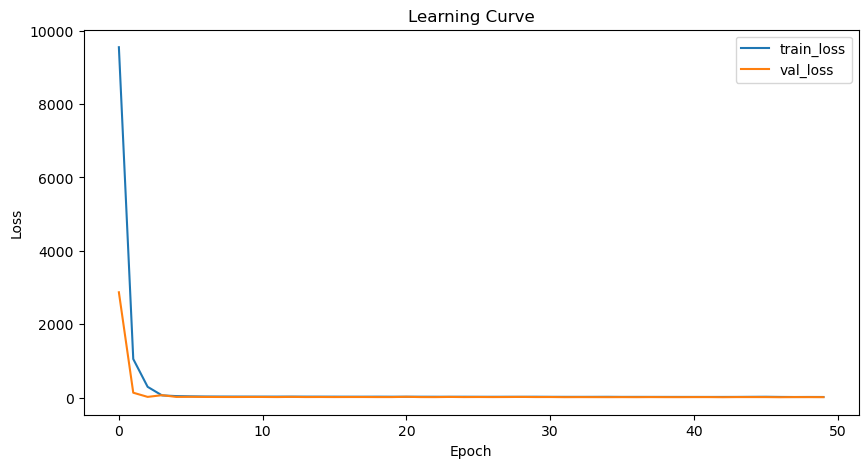

3/3 [==============================] - 0s 17ms/step


2023-04-27 00:59:04.545288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [92]:
'''Simple RNN'''
#define the model
model_UIRP3c = Sequential()
model_UIRP3c.add(SimpleRNN(64, activation='relu', kernel_regularizer=regularizers.l2(0.3), input_shape=(X_IRc.shape[1], X_IRc.shape[2])))
model_UIRP3c.add(Dense(n_forecast))
model_UIRP3c.compile(optimizer='adam', loss='mse')
# train the model and plot learning curve
history = None
history = model_UIRP3c.fit(X_IRc, train_y_IR, epochs=50, validation_data=(T_IRc, test_y_IR), verbose=0)
plot_learning_curve(history)
# demonstrate prediction
y_pred_UIRP3c = model_UIRP3c.predict(T_IRc)


In [93]:
evaluate(test_y_IR,y_pred_UIRP3c, T_IR)

'MAE: 2.6203, MSE: 12.3736, RMSE: 3.5176, MAPE: 2.2328, R2: 0.8674'

In [94]:
'''Compare UIRP against pure'''
from DMtest import dm_test
y= test_y_IR.flatten().tolist()
y_pred_u5= y_pred_UIRP3.flatten().tolist()
y_pred_u6= y_pred_UIRP3c.flatten().tolist()
rt = dm_test(y,y_pred_u5,y_pred_u6,h = 1, crit="poly", power=2)
print(rt)

dm_return(DM=0.03239769849483361, p_value=0.9742274437051153)


Direction four: Taylor Rule Model

In [11]:
'''Taylor Rule Model 包含了7个feature 分别是Et PPIt(POIt*) IPIt(IPIt*) LagIt(LagIt*)'''
#由于数据源的局限性，Interest Rate始于1985-07，所以作为Lag data， 其他数据将始于1985-08；
#同时，IPI截止于2023-01，所以所有数据截止于2023-01，Interest Rate 截止于2022-12

'''Exchange rate'''
data4=data[67:-2]#1985-08 至 2023-01

learn4,predict4=split_sequence(data4,n_month,n_forecast)
#取前80%数据用于训练,后20%用于测试
n4=int(predict4.shape[0]*0.8)
print(n4)
train_x_Taylor=learn4[:n4]
train_y_Taylor=predict4[:n4]
test_x_Taylor=learn4[n4:]
test_y_Taylor=predict4[n4:]
print(train_x_Taylor.shape,train_y_Taylor.shape,test_x_Taylor.shape,test_y_Taylor.shape)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_Taylor = train_x_Taylor.reshape((train_x_Taylor.shape[0], train_x_Taylor.shape[1], n_features))
T_Taylor = test_x_Taylor.reshape((test_x_Taylor.shape[0],test_x_Taylor.shape[1],n_features))

num4=data4.shape[0]

'''Interest Rate'''
#取原有的Interest rate作为lag input,即IR数据始于1985-07，截止到2022-12:
Lag_IN_JP,Lag_IN_JP_T,a = transform(IN_JP_IM.iloc[:-3],X_Taylor,T_Taylor,num4)
Lag_IN_US,Lag_IN_US_T,b = transform(IN_US_IM.iloc[66:-3],X_Taylor,T_Taylor,num4)

'''Inflation(PPI)'''
#PPI取1985-08至2023-01
INF_JP_Taylor,INF_JP_Taylor_T,c = transform(PPI_JP.iloc[67:-2],X_Taylor,T_Taylor,num4)
INF_US_Taylor,INF_US_Taylor_T,d = transform(PPI_US.iloc[67:-2],X_Taylor,T_Taylor,num4)

'''Output(IPI)'''
#IPI取1985-08至2023-01
IPI_JP_Taylor,IPI_JP_Taylor_T,e = transform(IPI_JP.iloc[67:],X_Taylor,T_Taylor,num4)
IPI_US_Taylor,IPI_US_Taylor_T,f = transform(IPI_US.iloc[67:],X_Taylor,T_Taylor,num4)


356
(356, 5) (356, 1) (89, 5) (89, 1)
renewed data size:(450,)
(356, 5) (356, 1) (89, 5) (89, 5)
renewed data size:(450,)
(356, 5) (356, 1) (89, 5) (89, 5)
renewed data size:(450,)
(356, 5) (356, 1) (89, 5) (89, 5)
renewed data size:(450,)
(356, 5) (356, 1) (89, 5) (89, 5)
renewed data size:(450,)
(356, 5) (356, 1) (89, 5) (89, 5)
renewed data size:(450,)
(356, 5) (356, 1) (89, 5) (89, 5)


In [12]:
#通过broadcast合并特征
X_Taylor = np.concatenate((X_Taylor, Lag_IN_JP, Lag_IN_US, np.log(INF_JP_Taylor), np.log(INF_US_Taylor), IPI_JP_Taylor, IPI_US_Taylor), axis=-1)

T_Taylor = np.concatenate((T_Taylor, Lag_IN_JP_T, Lag_IN_US_T, np.log(INF_JP_Taylor_T), np.log(INF_US_Taylor_T), IPI_JP_Taylor_T, IPI_US_Taylor_T), axis=-1)

print(X_Taylor.shape,T_Taylor.shape)

(356, 5, 7) (89, 5, 7)


In [13]:
X_Taylorc = X_Taylor[:,:,0].reshape((356,5,1))
T_Taylorc = T_Taylor[:,:,0].reshape((89,5,1))

In [14]:
'''Simple RNN'''
#define the model
model_Taylor0 = Sequential()
model_Taylor0.add(SimpleRNN(100, activation='relu', kernel_regularizer=regularizers.l2(0.3), input_shape=(X_Taylor.shape[1], X_Taylor.shape[2])))
model_Taylor0.add(Dense(n_forecast))
model_Taylor0.compile(optimizer='adam', loss='mse')

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-27 21:55:48.681587: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-27 21:55:48.681744: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2023-04-27 21:55:50.550453: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-27 21:55:50.834828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 21:55:51.410475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


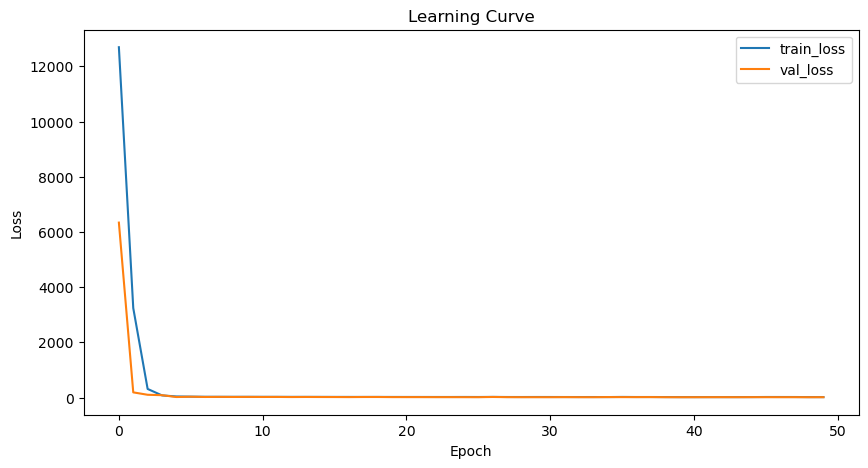

3/3 [==============================] - 0s 9ms/step


2023-04-27 21:56:03.337360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [15]:
# train the model and plot learning curve
history = None
history = model_Taylor0.fit(X_Taylor, train_y_Taylor, epochs=50, validation_data=(T_Taylor, test_y_Taylor), verbose=0)
plot_learning_curve(history)
# demonstrate prediction
y_pred_Taylor0 = model_Taylor0.predict(T_Taylor)

In [16]:
evaluate(test_y_Taylor,y_pred_Taylor0, T_Taylor)

'MAE: 2.6945, MSE: 13.0089, RMSE: 3.6068, MAPE: 2.3288, R2: 0.8486'

2023-04-27 21:56:11.832692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 21:56:12.316368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


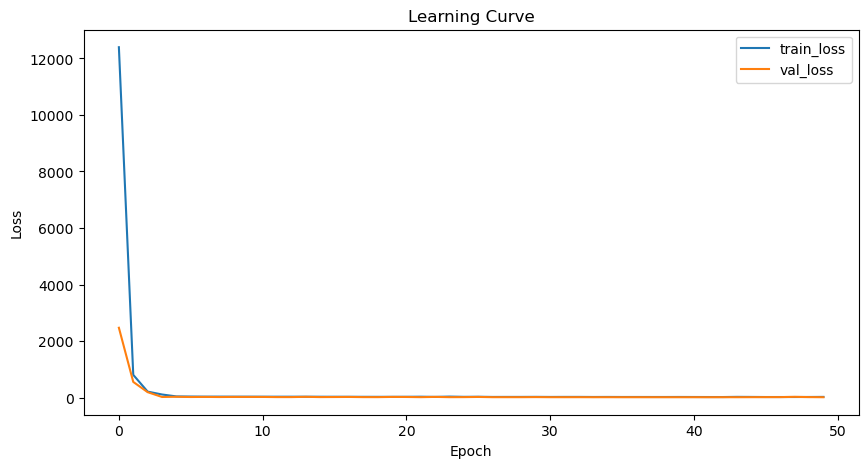

3/3 [==============================] - 0s 9ms/step


2023-04-27 21:56:24.204644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [17]:
'''Simple RNN'''
#define the model
model_Taylor0c = Sequential()
model_Taylor0c.add(SimpleRNN(100, activation='relu', kernel_regularizer=regularizers.l2(0.3), input_shape=(X_Taylorc.shape[1], X_Taylorc.shape[2])))
model_Taylor0c.add(Dense(n_forecast))
model_Taylor0c.compile(optimizer='adam', loss='mse')
# train the model and plot learning curve
history = None
history = model_Taylor0c.fit(X_Taylorc, train_y_Taylor, epochs=50, validation_data=(T_Taylorc, test_y_Taylor), verbose=0)
plot_learning_curve(history)
# demonstrate prediction
y_pred_Taylor0c = model_Taylor0c.predict(T_Taylorc)


In [18]:
evaluate(test_y_Taylor,y_pred_Taylor0c, T_Taylorc)

'MAE: 2.4414, MSE: 11.7046, RMSE: 3.4212, MAPE: 2.0776, R2: 0.8638'

In [19]:
'''Compare Taylor against pure'''
from DMtest import dm_test
y= test_y_Taylor.flatten().tolist()
y_pred_t1= y_pred_Taylor0.flatten().tolist()
y_pred_t2= y_pred_Taylor0c.flatten().tolist()
rt = dm_test(y,y_pred_t1,y_pred_t2,h = 1, crit="poly", power=2)
print(rt)

dm_return(DM=0.848867207293601, p_value=0.39825846000446163)


In [26]:
'''stacked Vanilla LSTM'''
# define model
model_Taylor = Sequential()
model_Taylor.add(LSTM(64, activation='relu', kernel_regularizer=regularizers.l2(0.3),input_shape=(X_Taylor.shape[1], X_Taylor.shape[2]),return_sequences=True))
model_Taylor.add(LSTM(64, activation='relu', kernel_regularizer=regularizers.l2(0.3),input_shape=(X_Taylor.shape[1], X_Taylor.shape[2])))
model_Taylor.add(Dense(n_forecast))
model_Taylor.compile(optimizer='adam', loss='mse')

2023-04-27 11:28:21.826143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 11:28:23.440766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


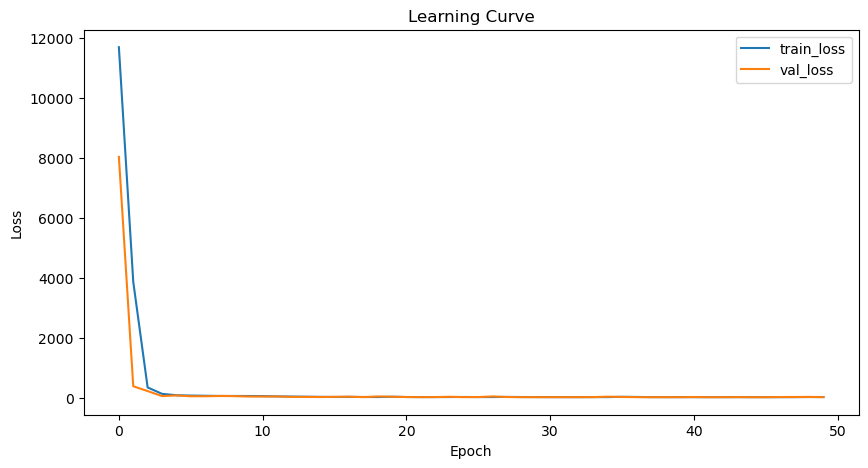

3/3 [==============================] - 0s 31ms/step


2023-04-27 11:29:09.346503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [27]:
# train the model and plot learning curve
history = None
history = model_Taylor.fit(X_Taylor, train_y_Taylor, epochs=50, validation_data=(T_Taylor, test_y_Taylor), verbose=0)
plot_learning_curve(history)
# demonstrate prediction
y_pred_Taylor = model_Taylor.predict(T_Taylor)

In [28]:
evaluate(test_y_Taylor,y_pred_Taylor, T_Taylor)

'MAE: 2.2310, MSE: 9.0011, RMSE: 3.0002, MAPE: 1.9286, R2: 0.8953'

2023-04-27 11:29:15.606187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 11:29:17.251255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


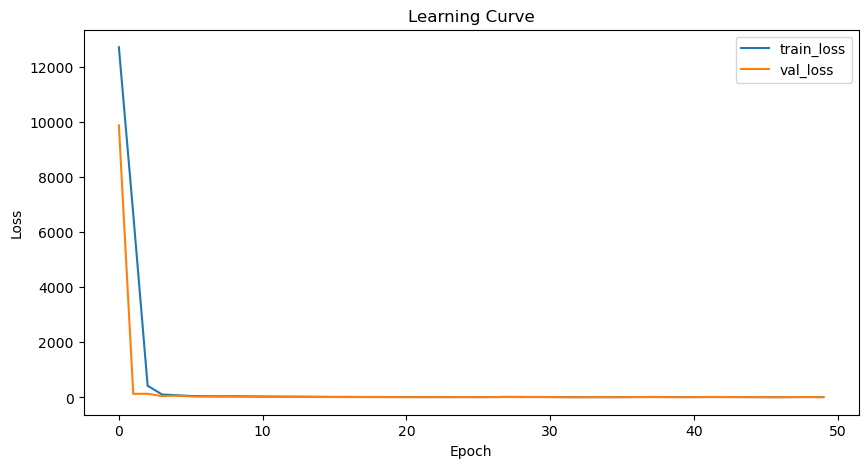

3/3 [==============================] - 0s 33ms/step


2023-04-27 11:30:03.656248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [29]:
'''stacked Vanilla LSTM'''
# define model
model_Taylorc = Sequential()
model_Taylorc.add(LSTM(64, activation='relu', kernel_regularizer=regularizers.l2(0.3),input_shape=(X_Taylorc.shape[1], X_Taylorc.shape[2]),return_sequences=True))
model_Taylorc.add(LSTM(64, activation='relu', kernel_regularizer=regularizers.l2(0.3),input_shape=(X_Taylorc.shape[1], X_Taylorc.shape[2])))
model_Taylorc.add(Dense(n_forecast))
model_Taylorc.compile(optimizer='adam', loss='mse')
# train the model and plot learning curve
history = None
history = model_Taylorc.fit(X_Taylorc, train_y_Taylor, epochs=50, validation_data=(T_Taylorc, test_y_Taylor), verbose=0)
plot_learning_curve(history)
# demonstrate prediction
y_pred_Taylorc = model_Taylorc.predict(T_Taylorc)


In [30]:
evaluate(test_y_Taylor,y_pred_Taylorc, T_Taylorc)

'MAE: 2.0176, MSE: 8.2055, RMSE: 2.8645, MAPE: 1.7114, R2: 0.9045'

In [31]:
'''Compare Taylor against pure'''
from DMtest import dm_test
y= test_y_Taylor.flatten().tolist()
y_pred_t1= y_pred_Taylor.flatten().tolist()
y_pred_t2= y_pred_Taylorc.flatten().tolist()
rt = dm_test(y,y_pred_t1,y_pred_t2,h = 1, crit="poly", power=2)
print(rt)

dm_return(DM=0.83412789170957, p_value=0.4064674864306129)


In [32]:
'''Bidirectional LSTM model'''

from keras.layers import Bidirectional
#define the model
model_Taylor2 = Sequential()
model_Taylor2.add(Bidirectional(LSTM(128, activation='relu',kernel_regularizer=regularizers.l2(0.3)), input_shape=(X_Taylor.shape[1], X_Taylor.shape[2])))
model_Taylor2.add(Dense(n_forecast))
model_Taylor2.compile(optimizer='adam', loss='mse')

2023-04-27 11:30:27.785712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 11:30:29.399103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


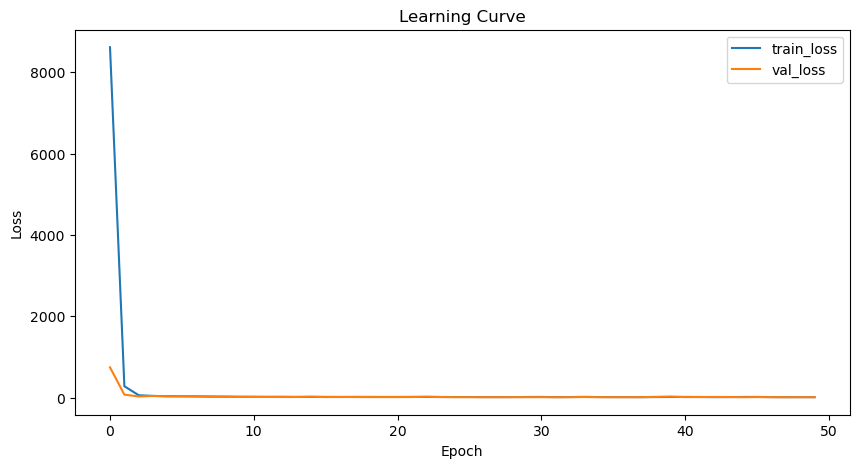

3/3 [==============================] - 0s 35ms/step


2023-04-27 11:31:11.105365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [33]:
# train the model and plot learning curve
history = None
history = model_Taylor2.fit(X_Taylor, train_y_Taylor, epochs=50, validation_data=(T_Taylor, test_y_Taylor), verbose=0)
plot_learning_curve(history)
# demonstrate prediction
y_pred_Taylor2 = model_Taylor2.predict(T_Taylor)

In [34]:
evaluate(test_y_Taylor,y_pred_Taylor2, T_Taylor)

'MAE: 2.1733, MSE: 9.4045, RMSE: 3.0667, MAPE: 1.8569, R2: 0.8906'

2023-04-27 11:31:18.600577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 11:31:20.278817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


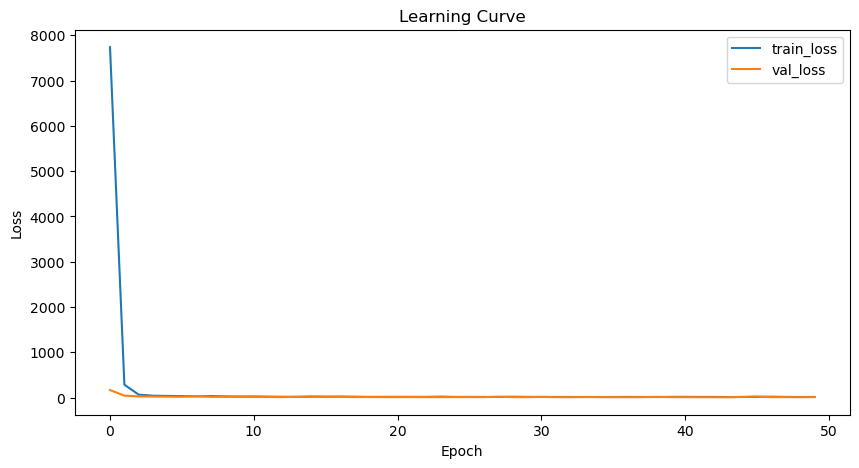

3/3 [==============================] - 0s 41ms/step


2023-04-27 11:32:01.699109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [35]:
'''Bidirectional LSTM model'''

from keras.layers import Bidirectional
#define the model
model_Taylor2c = Sequential()
model_Taylor2c.add(Bidirectional(LSTM(128, activation='relu',kernel_regularizer=regularizers.l2(0.3)), input_shape=(X_Taylorc.shape[1], X_Taylorc.shape[2])))
model_Taylor2c.add(Dense(n_forecast))
model_Taylor2c.compile(optimizer='adam', loss='mse')

# train the model and plot learning curve
history = None
history = model_Taylor2c.fit(X_Taylorc, train_y_Taylor, epochs=50, validation_data=(T_Taylorc, test_y_Taylor), verbose=0)
plot_learning_curve(history)
# demonstrate prediction
y_pred_Taylor2c = model_Taylor2c.predict(T_Taylorc)

In [36]:
evaluate(test_y_Taylor,y_pred_Taylor2c, T_Taylorc)

'MAE: 2.4567, MSE: 9.3299, RMSE: 3.0545, MAPE: 2.1438, R2: 0.8914'

In [37]:
'''Compare Taylor against pure'''
from DMtest import dm_test
y= test_y_Taylor.flatten().tolist()
y_pred_t1= y_pred_Taylor2.flatten().tolist()
y_pred_t2= y_pred_Taylor2c.flatten().tolist()
rt = dm_test(y,y_pred_t1,y_pred_t2,h = 1, crit="poly", power=2)
print(rt)

dm_return(DM=0.0384886960587463, p_value=0.9693852257014759)
